In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools
import datetime as dt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


In [2]:
pd.set_option('display.max_columns', 999)
pd.options.display.float_format = '{:20. 2f}'.format
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('Online_sports_DIB.csv').astype(str)

In [ ]:
df.dtypes

In [5]:
# Convert ReqTimeUTC back into time format

df['ReqTimeUTC'] = pd.to_datetime(df['ReqTimeUTC'])

In [6]:
# Convert Transaction Amount back into int we don't need the dollar fractions

df['TransactionAmount'] = pd.to_numeric(df['TransactionAmount']).astype(int)

In [ ]:
df.dtypes

In [ ]:
# Sweep df for nulls - none found

null = df[df.isnull().all(axis=1)].index
null

In [ ]:
df['TransactionType'].unique()

In [ ]:
#Status unique() says there are entries with nan - we only want approved deposits so these
# don't matter but we would still like to find them

df[df['Status'].str.contains('^nan')]

In [11]:
# New df to clean up the data

df_raw = df.copy()

In [ ]:
df_raw.info()

In [ ]:
# Change column names for ease of use

df_raw.rename(columns={ 'ReqTimeUTC': 'date', 'TransactionType': 'type',
                       'TransactionAmount': 'amount', 'Status': 'status',
                       'AccountIdentifier': 'patron'}, inplace=True)

df_raw.columns

In [14]:
 # Map new transaction types for ease of use
    # 'LOYALTYCARDCREDITACH': 'L1D', 'LOYALTYCARDDEBIT': 'L2D', 
    # 'LOYALTYCARDCREDITCL': 'L1D', 'LOYALTYCARDCREDIT': 'L2W'

df_raw['type'] = df_raw['type'] .map({'LOYALTYCARDCREDITACH': 'L1D', 
                                      'LOYALTYCARDDEBIT': 'L2D', 
                                      'LOYALTYCARDCREDITCL': 'L1D', 
                                      'LOYALTYCARDCREDIT': 'L2W'})


In [15]:
# Trim off the string 'customer' in front of the patron id number

df_raw['patron'] = df_raw['patron'].str.replace(r'^customer', '', regex=True)


In [ ]:
# Drop the time stamp from the date column

df_raw['date'] = pd.to_datetime(df_raw['date'])

df_raw.info()

In [ ]:
# New DF to work up the data using only L1D type

df_l1d = df_raw[df_raw['type'] == 'L1D']

df_l1d.reset_index(drop=True, inplace=True)
df_l1d

In [ ]:
# New df and include only APPROVED transaction

df_approved = df_l1d[df_l1d['status'] == 'APPROVED']

df_approved.reset_index(drop=True, inplace=True)

df_approved.columns

#df_approved['status'].unique()

In [ ]:
#New df to develop the features to be analysed - aggregate on patron

df_agg = df_approved.groupby(by='patron', as_index=False) \
.agg(
    value = ('amount', 'sum'),
    freq = ('amount', 'nunique'),
    last = ('date', 'max')
)

df_agg.head()

In [20]:
# Develop the recency feature 

max_date = df_agg['last'].max()

df_agg['recent'] = (max_date - pd.to_datetime(df_agg['last'])).dt.days

In [ ]:
df_agg.info()

In [ ]:
# Boxplot the RFM features

fig, ax = plt.subplots(ncols=3, figsize=(15,5))

sns.boxplot(data=df_agg['value'], color='skyblue', ax=ax[0])

sns.boxplot(data=df_agg['freq'], color='orange', ax=ax[1])

sns.boxplot(data=df_agg['recent'], color='salmon', ax=ax[2])


In [ ]:
# The boxplots for value and frequency show the same degree of outliers as the casino data. 
# Removing the outliers did not significantly ease this problem
# Use a scatterplot to check the raw distribution

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(df_agg['value'], df_agg['freq'], 
                     df_agg['recent'])

ax.set_xlabel('Deposit Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3-D Scatterplot of Aggregated Sports Data')

In [24]:
# The raw data is squashed over on the left side of the plot. 
# Theeffect of outliers is still evident
# Scaling a similar looking plot for the casino was not effective
# Try a log transformation of the data

selected_columns = ['value', 'freq', 'recent']

df_agg_log = df_agg[selected_columns].copy()

In [25]:
# Use a log transformation on this df

df_agg_log['value'] = np.log1p(df_agg_log['value'])
df_agg_log['freq'] = np.log1p(df_agg_log['freq'])
df_agg_log['recent'] = np.log1p(df_agg_log['recent'])

In [ ]:
# 3-D plot the log transformed data

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(df_agg_log['value'], df_agg_log['freq'], 
                     df_agg_log['recent'])

ax.set_xlabel('Deposit Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3-D Scatterplot of Log Transformed Sports Data')

In [27]:
# The scatterplot of the transformed data shows a similar result as the casino data. 
# This is useful since both data sets are on the same scaling so a comparison 
# will be valid

# Use KMeans clustering to develop the features

max_k = 12
inertia = []
silhouette_scores = []
k_values = range(2, 12)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(df_agg_log)
    sil_score = silhouette_score(df_agg_log, cluster_labels)
    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Sihouette Score')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()        

In [ ]:
# Consistent with the casino data the number of clusters is 5

kmeans =KMeans(n_clusters=5, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(df_agg_log)

cluster_labels

In [ ]:
df_agg_log['clusters'] = cluster_labels


In [ ]:
# New 3-D Plot of Log Transformed Data

cluster_colors = {0: '#1f77b4', # Blue
                  1: '#ff7f0e', # Orange
                  2: '#2ca02c', # Green
                  3: '#d62728', # Red
                  4: '#800080', # Purple
                  }

colors = df_agg_log['clusters'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(df_agg_log['value'], 
                     df_agg_log['freq'], 
                     df_agg_log['recent'],
                     c=colors,
                     marker = 'o')
                    

ax.set_xlabel('Deposit Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3-D Scatterplot of Log Transformed Sports Data by Cluster')


In [ ]:
# The 3-D plot shows nicely clustered data again consistent with 
# the casino data

# Create violin plots to complete the comparison 

Text(0, 0.5, 'Recency')

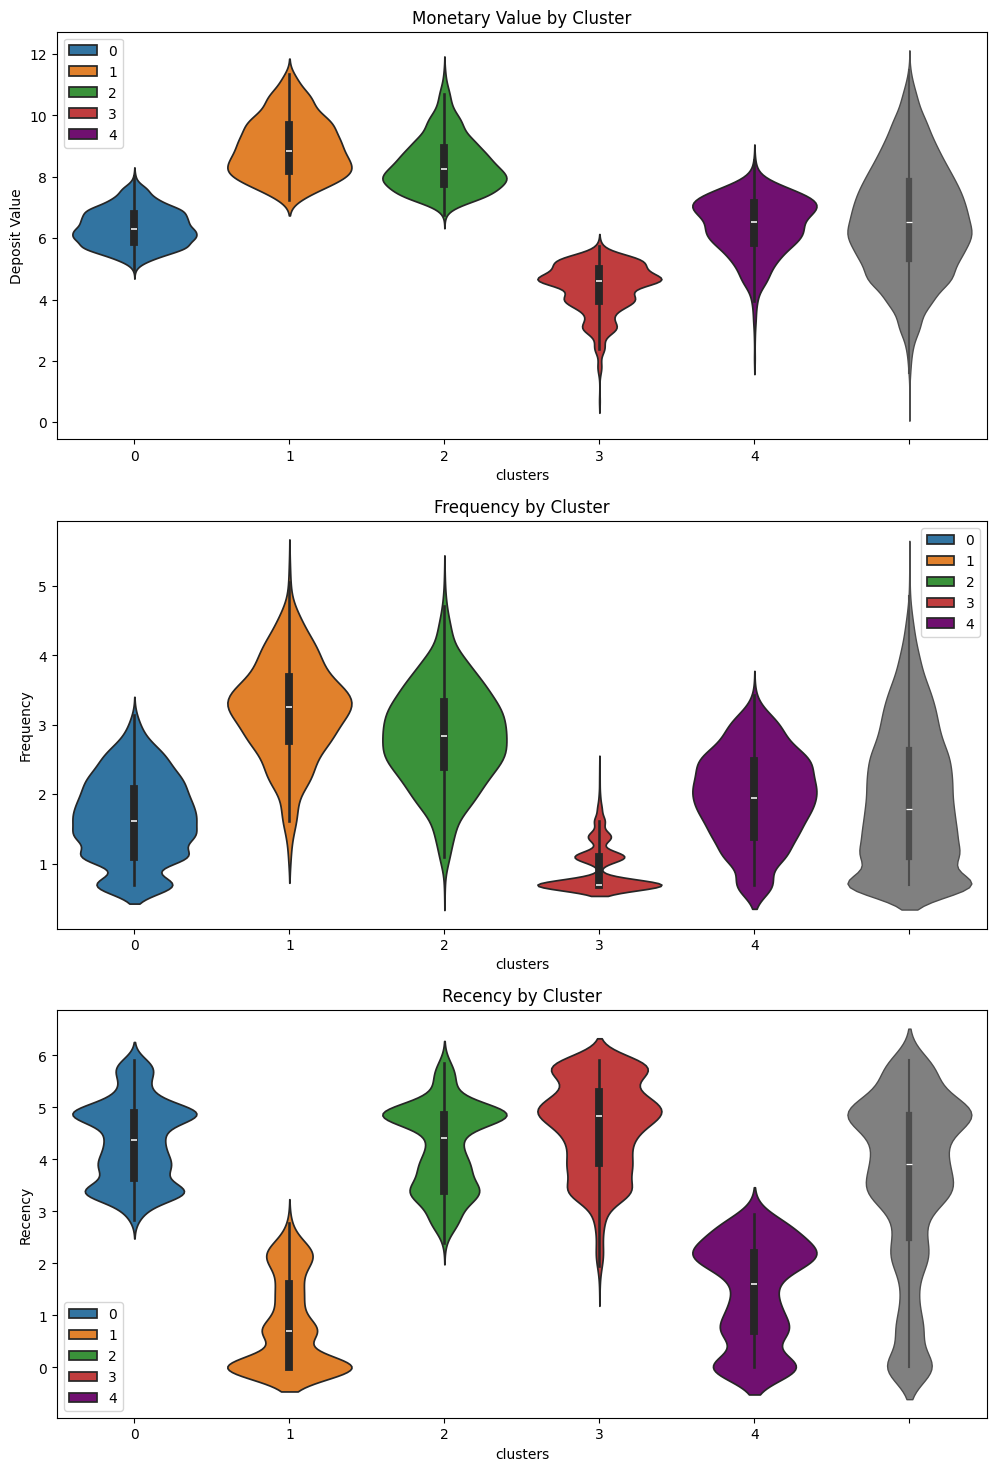

In [42]:
plt.figure(figsize=(12, 18))

plt.subplot( 3, 1, 1)

sns.violinplot(x=df_agg_log['clusters'], y=df_agg_log['value'],
               palette=cluster_colors,
               hue=df_agg_log['clusters'])

sns.violinplot(y=df_agg_log['value'], color='gray',
               linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Deposit Value')


plt.subplot( 3, 1, 2)

sns.violinplot(x=df_agg_log['clusters'], y=df_agg_log['freq'],
               palette=cluster_colors,
               hue=df_agg_log['clusters'])

sns.violinplot(y=df_agg_log['freq'], color='gray',
               linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot( 3, 1, 3)

sns.violinplot(x=df_agg_log['clusters'], y=df_agg_log['recent'],
               palette=cluster_colors,
               hue=df_agg_log['clusters'])
sns.violinplot(y=df_agg_log['recent'], color='gray',
               linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')